In [1]:
import math
from deprecated import deprecated
from typing import Optional
#import perceval as pcvl
from perceval import * 
import perceval as pcvl
from perceval.utils.algorithms.circuit_optimizer import CircuitOptimizer
import numpy as np
import perceval.components as comp
from perceval.utils.algorithms.simplification import simplify



# From unitary to optical circuit

In [198]:
a = np.array([[-0.33507084,  0.39943297,  0.65170842,  0.45124945],
       [-0.41323691, -0.26703507, -0.38253809,  0.65313842],
       [ 0.34233906, -0.6955    ,  0.56669493,  0.19272236],
       [ 0.71532844,  0.28525248, -0.23970794,  0.55751162]])


In [199]:
# Define the elements of the matrix
U = np.array([
    [-1/3, -np.sqrt(2)/3, np.sqrt(2)/3, 2/3],
    [np.sqrt(2)/3, -1/3, -2/3, np.sqrt(2)/3],
    [-np.sqrt(3+np.sqrt(6))/3, np.sqrt(3-np.sqrt(6))/3, -np.sqrt((3+np.sqrt(6))/2)/3, np.sqrt(1/6-1/(3*np.sqrt(6)))],
    [-np.sqrt(3-np.sqrt(6))/3, -np.sqrt(3+np.sqrt(6))/3, -np.sqrt(1/6-1/(3*np.sqrt(6))), -np.sqrt((3+np.sqrt(6))/2)/3]
])

U=a

matrix = Matrix(U)

In [200]:
matrix.is_unitary()

False

### First method

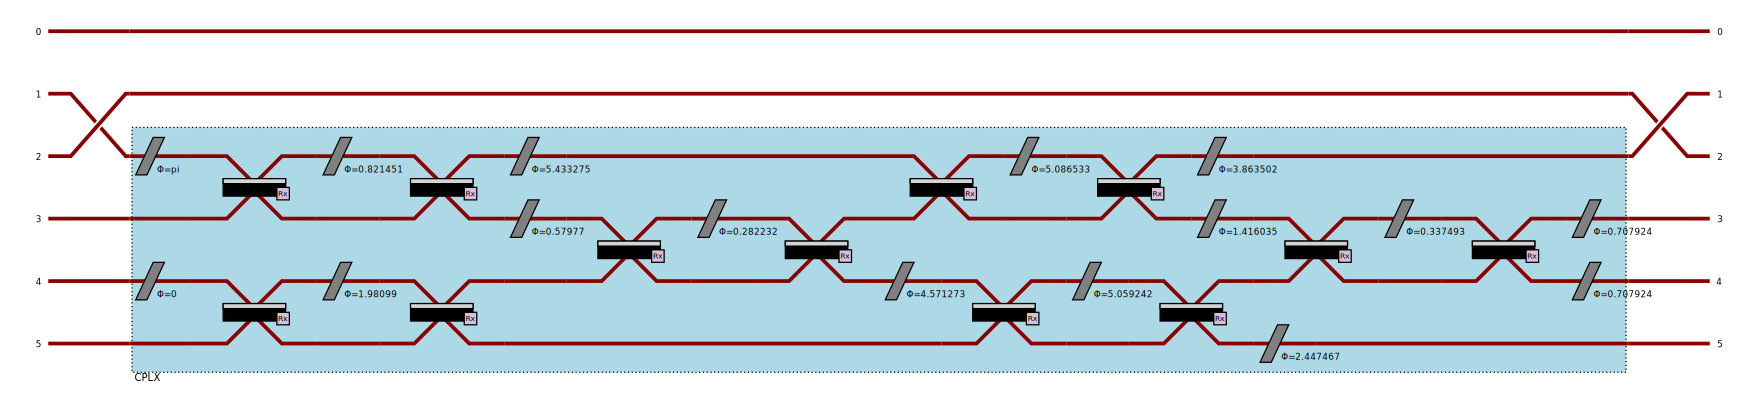

In [201]:
def mzi(i):
   return Circuit(2) // PS(P(f"phi_1_{i}")) // BS() // PS(P(f"phi_2_{i}")) // BS()
def ps(i):
   return PS(P(f"phi_3_{i}"))

template = GenericInterferometer(4, mzi, phase_shifter_fun_gen=ps, phase_at_output=True)


result_circuit, fidelity = CircuitOptimizer().optimize(matrix, template)
pdisplay(result_circuit, recursive=True)


# add the remaining nodes and express in rail encoding by doing a permutation
final_1 = Circuit(6)
final_1.add(0, comp.PERM([0, 2, 1, 3, 4, 5]))
final_1.add(2, result_circuit)
final_1.add(0, comp.PERM([0, 2, 1, 3, 4, 5]))
pcvl.pdisplay(final_1, recursive=True)

#print(f"Fidelity: {fidelity}")

### Second method

In [119]:
ub = comp.BS(theta=pcvl.P("theta")) // comp.PS(phi=pcvl.P("phi"))
C1 = pcvl.Circuit.decomposition(U,
                                ub,
                                shape="triangle")

pcvl.pdisplay(C1)

C1 = simplify(C1, display = False)

# add the remaining nodes and express in rail encoding by doing a permutation
final_2 = Circuit(6)
final_2.add(0, comp.PERM([0, 2, 1, 3, 4, 5]))
final_2.add(2, C1)
final_2.add(0, comp.PERM([0, 2, 1, 3, 4, 5]))
pcvl.pdisplay(final_2, recursive=True)

pdisplay(final_2, recursive=True)


ValueError: decomposed matrix should be non symbolic unitary

# Take the circuit and add the heralds

In [210]:
def build_processor(modes, C, herald_indexes, change_basis = False, mode_basis_change=0):
    processor = pcvl.Processor("SLOS", modes)

    if change_basis:
        processor.add(mode_basis_change, pcvl.BS.H())
        processor.add(0,  comp.PERM([1, 0, 3, 2]))


    processor.add(0, C)
    for i in herald_indexes:
        processor.add_herald(i,1)

    if change_basis:
        processor.add(mode_basis_change, pcvl.BS.H())
        processor.add(0,  comp.PERM([1, 0, 3, 2]))
    return processor

## First method

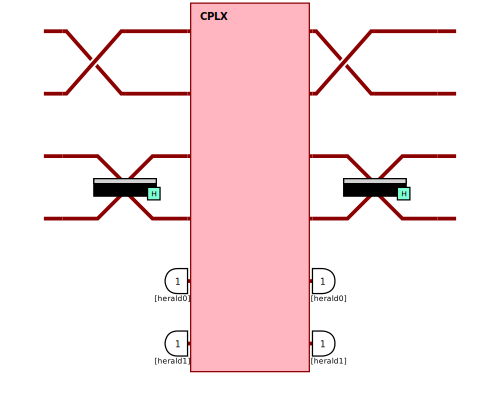

In [207]:
processor = build_processor(6, final_1, [4,5], change_basis=True, mode_basis_change=2)
pcvl.pdisplay(processor)


In [208]:

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(
    f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,00,01,10,11
00,0.971753,0.028247,0,0
01,0.028247,0.971753,0,0
10,0,0,0.027985,0.972015
11,0,0,0.972015,0.027985


performance = 0.07424162312898729, fidelity = 0.9718838655222033


## Second method

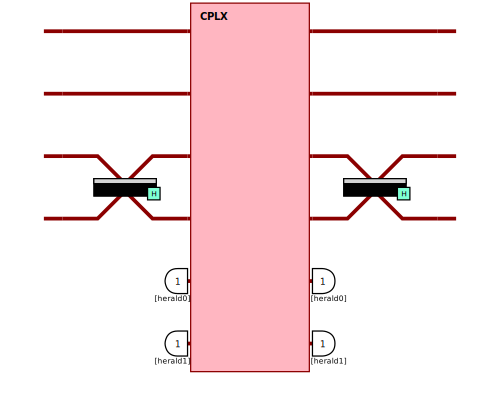

In [69]:
processor = build_processor(6, final_2, [4,5], change_basis=True, mode_basis_change=2)
#processor.add(0, comp.PERM([2, 3, 0, 1]))
pcvl.pdisplay(processor)


In [70]:

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(
    f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,00,01,10,11
00,0,1,0,0
01,1,0,0,0
10,0,0,1,0
11,0,0,0,1


performance = 0.07407407383516808, fidelity = 0.0


# CCZ

In [248]:
def build_processor(modes, C, herald_indexes, change_basis = False, mode_basis_change=0):
    processor = pcvl.Processor("SLOS", modes)

    if change_basis:
        processor.add(mode_basis_change, pcvl.BS.H())
        #processor.add(0,  comp.PERM([1, 0, 3, 2]))


    processor.add(0, C)
    for i in herald_indexes:
        processor.add_herald(i,1)

    if change_basis:
        processor.add(mode_basis_change, pcvl.BS.H())
        processor.add(0,  comp.PERM([1, 0]))
    return processor

In [249]:
# Given array
array = [
    [1.00050057e+00, -1.97125585e+00, 6.41240889e-01, 1.17478198e+00, -7.85131318e-02, 1.75119448e+00],
    [-1.42475437e+00, 1.50209773e+00, -5.86004693e-01, 1.46572683e+00, -7.39201837e-02, 2.37011908e+00],
    [3.38102724e-02, -1.45496088e+00, -4.94541751e-01, 1.71560691e+00, 1.06515694e-01, -4.98504150e-01],
    [2.21434090e-01, 1.18809853e+00, 3.03081108e+00, 1.31107407e+00, -1.35968060e-01, -6.99389255e-01],
    [2.83051274e+00, 1.43555626e+00, -4.56329083e-01, -4.56098445e-01, 1.42749749e-01, 9.88728256e-01],
    [-2.19669288e-01, 1.59550364e-03, 2.09581885e-01, -6.12932596e-02, 3.58386617e+00, 1.00339534e-01]
]

# Create the numpy array
matrix = np.array(array)
matrix = matrix/np.linalg.norm(matrix,2)


matrix = Matrix(matrix)


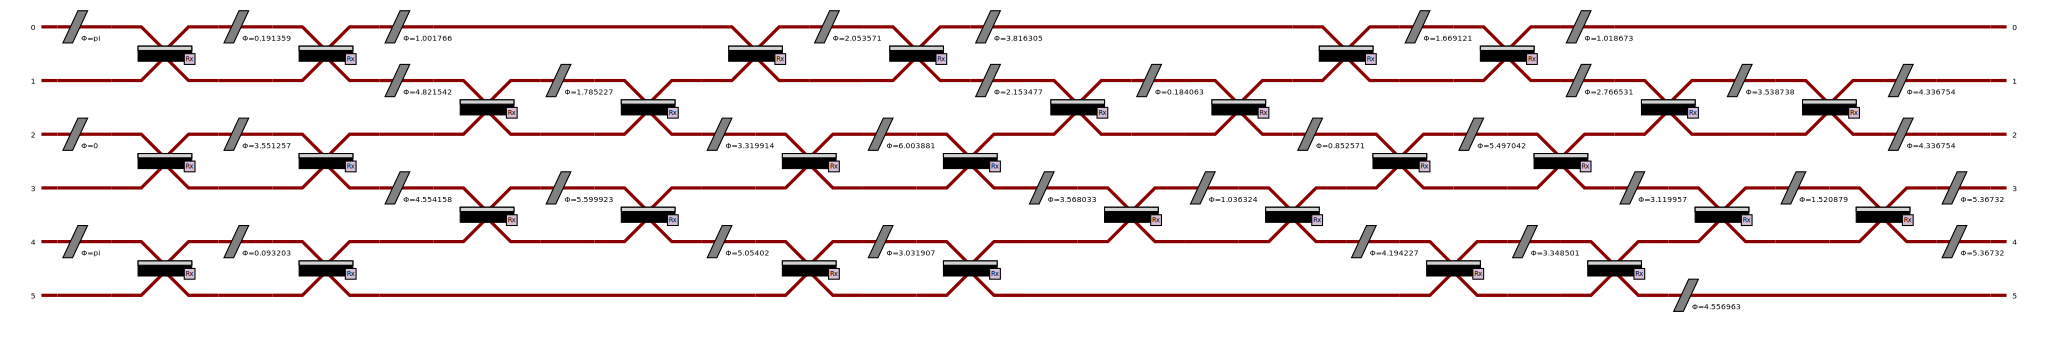

In [250]:
def mzi(i):
   return Circuit(2) // PS(P(f"phi_1_{i}")) // BS() // PS(P(f"phi_2_{i}")) // BS()
def ps(i):
   return PS(P(f"phi_3_{i}"))

template = GenericInterferometer(6, mzi, phase_shifter_fun_gen=ps, phase_at_output=True)


result_circuit, fidelity = CircuitOptimizer().optimize(matrix, template)
pdisplay(result_circuit, recursive=True)

pcvl.pdisplay(result_circuit, recursive=True)

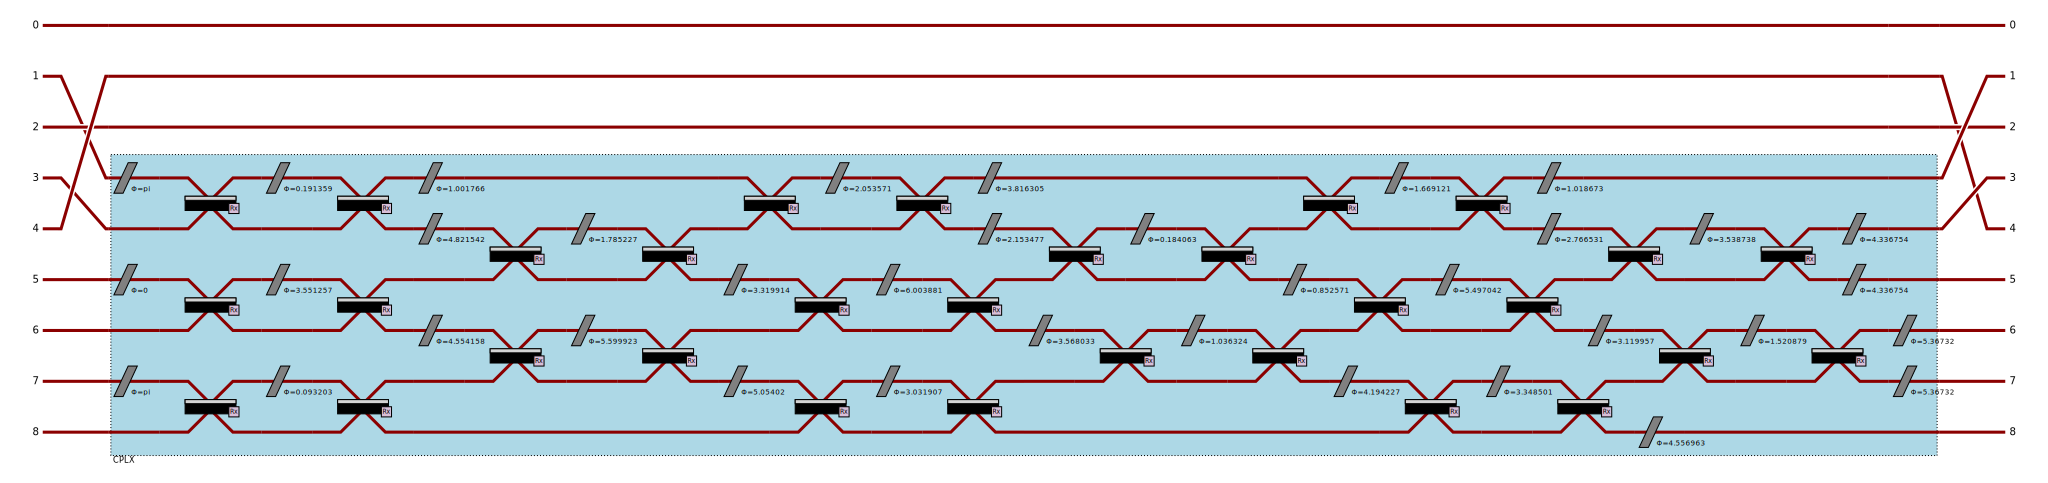

In [251]:
final = Circuit(9)
final.add(0, comp.PERM([0, 3, 2, 4, 1, 5, 6, 7, 8]))
final.add(3, result_circuit)
final.add(0, comp.PERM([0, 4, 2, 1, 3, 5, 6, 7, 8]))
pcvl.pdisplay(final, recursive=True)


In [252]:



processor = build_processor(9, final, [6,7,8], change_basis=True, mode_basis_change=4)
#pcvl.pdisplay(processor)


states = {pcvl.BasicState('|1,0,1,0,1,0>'): '000',
            pcvl.BasicState('|1,0,1,0,0,1>'): '001',
            pcvl.BasicState('|1,0,0,1,1,0>'): '010',
            pcvl.BasicState('|1,0,0,1,0,1>'): '011',
            pcvl.BasicState('|0,1,1,0,1,0>'): '100',
            pcvl.BasicState('|0,1,1,0,0,1>'): '101',
            pcvl.BasicState('|0,1,0,1,1,0>'): '110',
            pcvl.BasicState('|0,1,0,1,0,1>'): '111'}

ca = pcvl.algorithm.Analyzer(processor, states)

truth_table = {"000": "000", "001": "001", "010": "010", "011": "011",
            "100": "100", "101": "101", "110": "111", "111": "110"}

ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(
    f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")





Esempio che avevo fatto per capire

In [107]:
def example_build_circuit(theta1, theta2):
    last_modes_cz = (Circuit(4)
                        .add(0, PS(math.pi), x_grid=1)
                        .add(3, PS(math.pi), x_grid=1)
                        .add((1, 2), PERM([1, 0]), x_grid=1)
                        .add((0, 1), BS.H(theta=theta1), x_grid=2)
                        .add((2, 3), BS.H(theta=theta1), x_grid=2)
                        .add((1, 2), PERM([1, 0]))
                        .add((0, 1), BS.H(theta=-theta1))
                        .add((2, 3), BS.H(theta=theta2)))

    return (Circuit(6, name="Heralded CZ")
            .add(1, PERM([1, 0]))
            .add(2, last_modes_cz, merge=True)
            .add(1, PERM([1, 0])))

#pcvl.pdisplay(build_circuit(0, 0))


In [185]:
# Define specific values for theta1 and theta2
theta1 = 2*math.pi*54.74/180
theta2 = 2*math.pi*17.63/180

p = build_processor(6, example_build_circuit(theta1, theta2), [4, 5], change_basis=True, mode_basis_change=2)

states = {
    pcvl.BasicState([1, 0, 1, 0]): "00",
    pcvl.BasicState([1, 0, 0, 1]): "01",
    pcvl.BasicState([0, 1, 1, 0]): "10",
    pcvl.BasicState([0, 1, 0, 1]): "11"
}

ca = pcvl.algorithm.Analyzer(p, states)

truth_table = {"00": "00", "01": "01", "10": "11", "11": "10"}
ca.compute(expected=truth_table)

pcvl.pdisplay(ca)
print(
    f"performance = {ca.performance}, fidelity = {ca.fidelity.real}")

,00,01,10,11
00,1,0,0,0
01,0,1,0,0
10,0,0,0,1
11,0,0,1,0


performance = 0.07406604842851151, fidelity = 0.9999999915267557


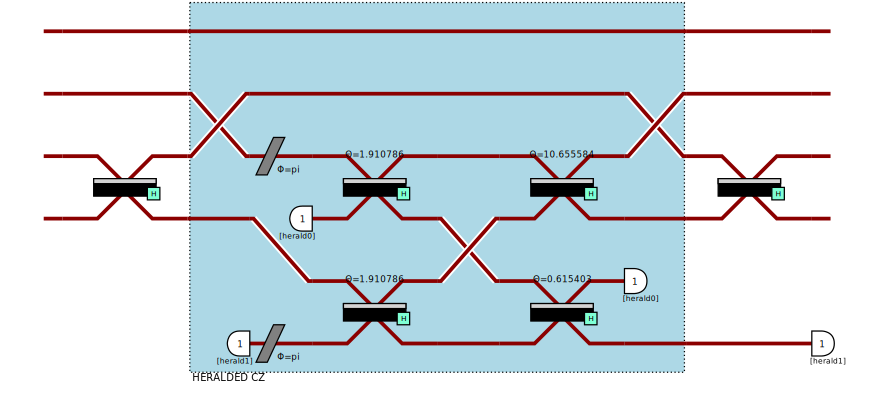

In [186]:
pcvl.pdisplay(p, recursive=True)
